In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import numpy as np
import shap
import seaborn as sns
import copy

seed = 110
random.seed(seed)
np.random.seed(seed)
plt.style.use("seaborn-v0_8")
sns.set(color_codes=True)

In [4]:
diabetes_df = pd.read_csv("diabetes_dataset.csv")
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(diabetes_df.drop(["Outcome", "Pregnancies"], axis=1),), columns=["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"])
y = diabetes_df.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# get the value range of "Glucose" and "BMI"
diabetes_df["Glucose"].max()

diabetes_df["Glucose"].min()

print(diabetes_df["BMI"].max())
print(diabetes_df["BMI"].min())


67.1
0.0


## Decision Tree
We do not need to normalise the feature values

In [5]:
# X = pd.DataFrame(diabetes_df.drop(["Outcome", "Pregnancies"], axis=1), columns=["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"])
# y = diabetes_df.Outcome
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(X_train.iloc[4])

Glucose                     88.000
BloodPressure               74.000
SkinThickness               19.000
Insulin                     53.000
BMI                         29.000
DiabetesPedigreeFunction     0.229
Age                         22.000
Name: 158, dtype: float64


In [18]:
# Important features: ("Glucose", "BMI", "Age")
tree_params = {
    "min_impurity_decrease": np.linspace(0, 0.4, 20),
    # "max_depth": [1, 2, 3, 4, 5],
    # "min_samples_split": [5, 10, 15],
}
tree_grid = GridSearchCV(
    estimator = DecisionTreeClassifier(),
    param_grid = tree_params,
)
tree_grid.fit(X_train, y_train)
print(tree_grid.best_params_)
print(tree_grid.best_estimator_.score(X_test, y_test))

tree_clf = DecisionTreeClassifier(min_impurity_decrease=0.01)
tree_clf.fit(X_train, y_train)
print(tree_clf.score(X_test, y_test))


{'min_impurity_decrease': 0.021052631578947368}
0.7727272727272727
0.7727272727272727


In [19]:
f1_score(y_test, tree_clf.predict(X_test))

0.6236559139784946

[Text(0.5, 0.875, 'x[0] <= 0.621\ngini = 0.461\nsamples = 614\nvalue = [393, 221]'),
 Text(0.25, 0.625, 'x[6] <= 0.125\ngini = 0.304\nsamples = 358\nvalue = [291, 67]'),
 Text(0.125, 0.375, 'gini = 0.153\nsamples = 203\nvalue = [186, 17]'),
 Text(0.375, 0.375, 'x[4] <= 0.393\ngini = 0.437\nsamples = 155\nvalue = [105, 50]'),
 Text(0.25, 0.125, 'gini = 0.061\nsamples = 32\nvalue = [31, 1]'),
 Text(0.5, 0.125, 'gini = 0.479\nsamples = 123\nvalue = [74, 49]'),
 Text(0.75, 0.625, 'x[4] <= 0.446\ngini = 0.479\nsamples = 256\nvalue = [102, 154]'),
 Text(0.625, 0.375, 'gini = 0.45\nsamples = 73\nvalue = [48, 25]'),
 Text(0.875, 0.375, 'gini = 0.416\nsamples = 183\nvalue = [54, 129]')]

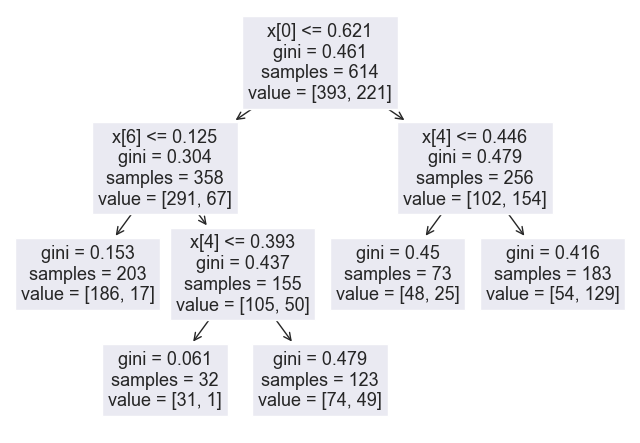

In [202]:
tree.plot_tree(tree_clf)

In [20]:
inv_df = pd.DataFrame([[0.621, 0, 0, 0, 0.446, 0, 0.125]], columns=["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"])
dt_inv_tf = scaler.inverse_transform(inv_df)
print(dt_inv_tf)

[[1.23579e+02 0.00000e+00 0.00000e+00 0.00000e+00 2.99266e+01 7.80000e-02
  2.85000e+01]]


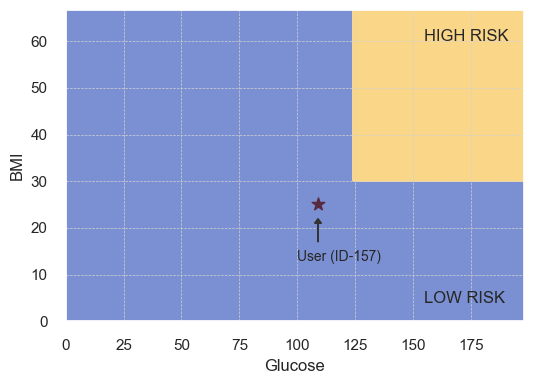

In [21]:
# x1: glucose, x2: BMI
feature1= "Glucose"
feature2= "BMI"
x1_min= np.min(list(X_train[feature1]), axis=0)
x1_max = np.max(list(X_train[feature1]), axis=0)
x2_min = np.min(list(X_train[feature2]), axis=0)
x2_max = np.max(list(X_train[feature2]), axis=0)
h=0.005

x1_cords, x2_cords = np.meshgrid(
    np.arange(x1_min, x1_max, h),
    np.arange(x2_min, x2_max, h)
)

# target point, let's say: 30
target_idx = 157
target_point = X.iloc[target_idx]
# print(target_point)
# print(diabetes_df.iloc[target_idx])
new_combinations = np.c_[x1_cords.ravel(), x2_cords.ravel()]
new_X = pd.DataFrame()
for feature in X_train.columns.values:
    if feature == feature1:
        new_X[feature1] = new_combinations.T[0]
    elif feature == feature2:
        new_X[feature2] = new_combinations.T[1]
    else:
        new_X[feature] = target_point[feature]
height_values = tree_clf.predict(new_X)
height_values = height_values.reshape(x1_cords.shape)

# inverse transform the scale of features
x1_cords_inver, x2_cords_inver = np.meshgrid(
    np.arange(diabetes_df[feature1].min(), round(diabetes_df[feature1].max()), round(diabetes_df[feature1].max())/200),
    np.arange(diabetes_df[feature2].min(), round(diabetes_df[feature2].max()), round(diabetes_df[feature2].max())/200)
)
# inver_target_point = scaler.inverse_transform(X_train)[target_idx]
inver_target_point = scaler.inverse_transform(X)[target_idx]


dots_color_mapping = mpl.colors.ListedColormap(["#7B90D2", "#FAD689"])
fig, ax = plt.subplots(figsize=(5.5, 4))
contour = ax.contourf(
    x1_cords_inver,     #x1_cords,
    x2_cords_inver,     #x2_cords,
    height_values,
    levels = 20,
    cmap = dots_color_mapping,
    zorder = 0,

)
ax.set_xlabel(feature1)
ax.set_ylabel(feature2)

# set legend
proxy = [plt.Rectangle((0,0),1,1, fc = pc.get_facecolor()[0], edgecolor="white", linewidth=2.0) for pc in [contour.collections[-1], contour.collections[0]]]
# plt.legend(proxy, ["High Risk", "Low Risk"], loc="lower right", labelcolor = "black")

plt.text(155, 60, "HIGH RISK")
plt.text(155, 4, "LOW RISK")
plt.text(100, 13, "User (ID-157)", fontsize=10)
plt.arrow(109, 17, 0, 5, head_width=3, head_length=1, length_includes_head=True, color="#333333")

ax.scatter(inver_target_point[np.where(X_train.columns.values == feature1)], 
           inver_target_point[np.where(X_train.columns.values == feature2)],
           c="#572A3F",
           edgecolors="#572A3F",
           marker="*",
           s=90)
ax.grid(which='major', color='lightgray', 
        linestyle='--', linewidth=0.5)

# plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/dt_decision_surface.png", dpi=300, transparent=True)
plt.show()

In [11]:
import graphviz
dot_data = tree.export_graphviz(tree_clf, out_file=None, feature_names = tree_clf.feature_names_in_, class_names=list(map(str, tree_clf.classes_)), filled=True, rounded=True, special_characters=True)
tree_structure_graph = graphviz.Source(dot_data)
plt.show()
# tree_structure_graph

In [86]:
tree_ft_df = pd.DataFrame()
tree_ft_df[X_train.columns.values] = [tree_clf.feature_importances_]
print(tree_ft_df.head())
tree_ft_df.sort_values(by=0, axis=1, ascending=False, inplace=True)

    Glucose  BloodPressure  SkinThickness  Insulin       BMI   
0  0.626358            0.0            0.0      0.0  0.251138  \

   DiabetesPedigreeFunction       Age  
0                       0.0  0.122504  


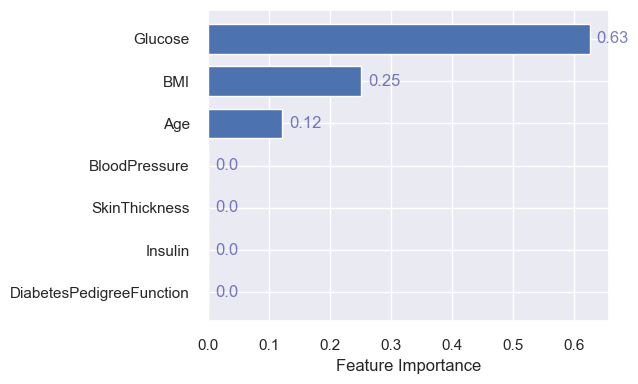

In [87]:
fig, ax = plt.subplots(figsize=(6.5,4))
tree_ft_plot = ax.barh(np.arange(tree_ft_df.shape[1]), 
               tree_ft_df.iloc[0, :], 
               tick_label=tree_ft_df.columns.values, 
               height=0.7)
ax.invert_yaxis()
ax.set_xlabel("Feature Importance")
ax.bar_label(container = tree_ft_plot,
             labels=tree_ft_df.iloc[0,:].round(2),
             padding=5, c="navy", alpha=0.5)
plt.tight_layout()
plt.savefig("../figures/dt_feature_importance.png", dpi=300, transparent=True)
plt.show()

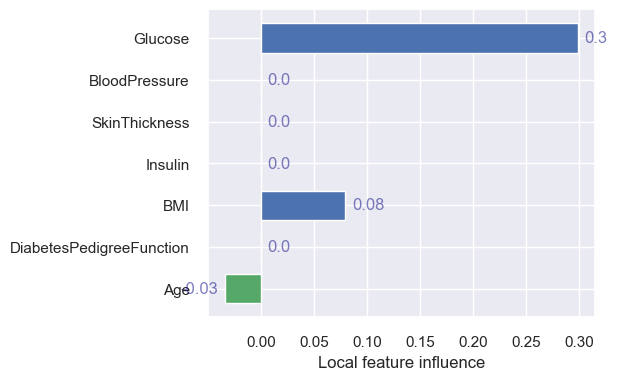

In [59]:
tree_explainer = shap.TreeExplainer(tree_clf)
tree_shap_values = tree_explainer.shap_values(X_test)
# sns.set()

dt_ft_influence = tree_shap_values[1][5]

fig, ax = plt.subplots(figsize=(5,4))
colors = ['b' if e >= 0 else 'g' for e in dt_ft_influence]

dt_ft_plot = ax.barh(np.arange(dt_ft_influence.shape[0]), 
               dt_ft_influence, 
               tick_label=X_train.columns.values, 
               color = colors,
               height=0.7)
ax.invert_yaxis()
# ax.set_xlim(-2, 6)
ax.set_xlabel("Local feature influence")
ax.bar_label(container = dt_ft_plot,
             labels=dt_ft_influence.round(2),
             padding=5, c="navy", alpha=0.5)
plt.show()

## Logistic Regression

We need to normalise the data

In [6]:
# Logistic regression
lr_params = {
    "penalty": ["l2", None],
    "tol": np.linspace(1e-4, 1e-2, 10),
    "max_iter": np.arange(50, 150, 10),
    "solver": ["lbfgs"],
    # "C": np.arange(0.3, 1.1, 10)
}

lr_grid = GridSearchCV(
    LogisticRegression(),
    lr_params
)
lr_grid.fit(X_train, y_train)
print(lr_grid.best_estimator_.score(X_test, y_test))
print(lr_grid.best_params_)

lr_clf = LogisticRegression(penalty=None, tol = 1e-4)
lr_clf.fit(X_train, y_train)
print(lr_clf.get_params())
print(lr_clf.score(X_test, y_test))

0.8116883116883117
{'max_iter': 50, 'penalty': None, 'solver': 'lbfgs', 'tol': 0.0001}
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': None, 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.8116883116883117


In [7]:
coef_df = pd.DataFrame()
coef_df["Bias"] = lr_clf.intercept_
# coef_df = pd.DataFrame(lr_clf.coef_, columns=X_train.columns.values)
coef_df[X_train.columns.values] = np.absolute(lr_clf.coef_)
print(coef_df.head())
lr_ft_weight = coef_df.iloc[0, 1:].to_frame().transpose()
lr_ft_weight.sort_values(by=0, axis=1, ascending=False, inplace=True)

       Bias   Glucose  BloodPressure  SkinThickness   Insulin       BMI   
0 -7.250947  6.205386        1.39334       0.644334  1.124015  5.628819  \

   DiabetesPedigreeFunction       Age  
0                  2.059352  2.182759  


In [60]:
# Verify algorithmic explanation
import math

cf_df = pd.DataFrame([[124, 70, 33, 402, 35.4, 0.282, 34]], columns=["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"])
cf_scaled = scaler.transform(cf_df)

cf_prediction = lr_clf.predict(cf_scaled)
print(cf_scaled)
print(cf_prediction)

print(lr_clf.coef_)
lr_result = 1/ (1+ math.exp(-(1*(-7.25) + 0.62*6.21 - 1.39 * 0.57 + 0.64 * 0.33 - 1.12 * 0.48 + 5.63 * 0.53 + 2.06* 0.09 + 2.18 * 0.22)))
print(lr_result)

[[0.62311558 0.57377049 0.33333333 0.4751773  0.52757079 0.08710504
  0.21666667]]
[0]
[[ 6.20538579 -1.39334046  0.64433355 -1.12401467  5.6288186   2.05935243
   2.18275868]]
0.2953375404975491


X does not have valid feature names, but LogisticRegression was fitted with feature names


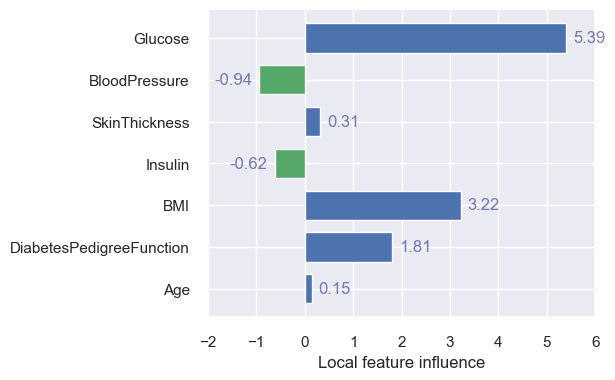

In [61]:
lr_clf.coef_
data_point = X_train.iloc[4]
lr_ft_influence = data_point*(lr_clf.coef_[0])

fig, ax = plt.subplots(figsize=(5,4))
colors = ['b' if e >= 0 else 'g' for e in lr_ft_influence]

lr_ft_plot = ax.barh(np.arange(lr_ft_influence.shape[0]), 
               lr_ft_influence, 
               tick_label=X_train.columns.values, 
               color = colors,
               height=0.7)
ax.invert_yaxis()
ax.set_xlim(-2, 6)
ax.set_xlabel("Local feature influence")
ax.bar_label(container = lr_ft_plot,
             labels=lr_ft_influence.round(2),
             padding=5, c="navy", alpha=0.5)
plt.show()

In [10]:
# Normalise the feature coefficients for logistic regression so that they add up to one.
lr_ft_weight_scaled = pd.DataFrame()
weight_sum = lr_ft_weight.sum(axis=1)[0]

for index, column in enumerate(lr_ft_weight.iloc[0, :]):
    scaled_value = column/weight_sum
    header = lr_ft_weight.columns[index]
    lr_ft_weight_scaled[header] = [scaled_value]

print(lr_ft_weight_scaled.round(2))
lr_ft_weight_scaled = lr_ft_weight_scaled.round(2)


   Glucose   BMI   Age  DiabetesPedigreeFunction  BloodPressure  Insulin   
0     0.32  0.29  0.11                      0.11           0.07     0.06  \

   SkinThickness  
0           0.03  


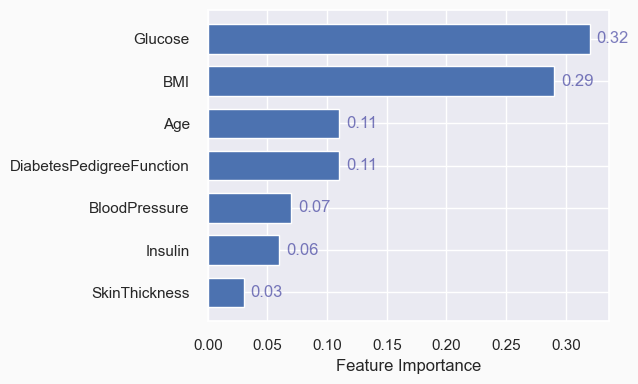

In [11]:
fig, ax = plt.subplots(figsize=(6.5,4), facecolor="#fafafa")
lr_ft_plot = ax.barh(np.arange(lr_ft_weight_scaled.shape[1]), 
               lr_ft_weight_scaled.iloc[0, :], 
               tick_label=lr_ft_weight_scaled.columns.values, 
               height=0.7)
ax.invert_yaxis()
ax.set_xlabel("Feature Importance")
ax.bar_label(container = lr_ft_plot,
             labels=lr_ft_weight_scaled.iloc[0,:].round(2),
             padding=5, c="navy", alpha=0.5)
plt.tight_layout()
plt.savefig("../figures/lr_feature_importance.png", dpi=300, transparent=True)
plt.show()

In [54]:
# Get the decision surface of the logistic regression

# X_local = X_test.iloc[:,[0,4]] 
# _, ax = plt.subplots(figsize=(4, 3))
# lr_clf.fit(X_train.iloc[:,[0,4]], y_train)
# plt.style.use("seaborn-v0_8")
# surface = DecisionBoundaryDisplay.from_estimator(
#     lr_clf,
#     X_local,
#     cmap="coolwarm",
#     ax=ax,
#     response_method="predict",
#     # plot_method="",
#     # shading="auto",
#     xlabel="Glucose",
#     ylabel="BMI",
#     eps=0.5,
#     alpha=0.8
# )
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# # plt.colorbar(surface, ax=ax)
# # Plot also the training points
# plt.scatter(X_test.iloc[:100, 0], X_test.iloc[:100, 4], 
#             c=y_test[:100], 
#             edgecolors="k", 
#             cmap=plt.cm.RdPu,
#             s=30
#             )

# # plt.xticks(())
# # plt.yticks(())

# plt.show()

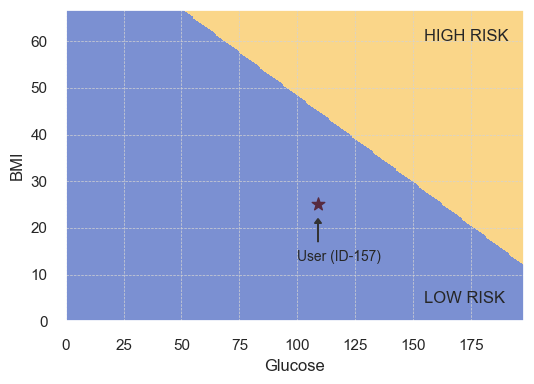

In [223]:
height_values = lr_clf.predict(new_X)
height_values = height_values.reshape(x1_cords.shape)

dots_color_mapping = mpl.colors.ListedColormap(["#7B90D2", "#FAD689"])
fig, ax = plt.subplots(figsize=(5.5, 4))
contour = ax.contourf(
    x1_cords_inver,
    x2_cords_inver,
    height_values,
    levels = 20,
    cmap = dots_color_mapping,
    zorder = 0,
)

ax.set_xlabel(feature1)
ax.set_ylabel(feature2)

# set legend
proxy = [plt.Rectangle((0,0),1,1, fc = pc.get_facecolor()[0], edgecolor="white", linewidth=2.0) for pc in [contour.collections[-1], contour.collections[-0]]]
# plt.legend(proxy, ["High Risk", "Low Risk"], loc="lower right", labelcolor = "black" )
plt.text(155, 60, "HIGH RISK")
plt.text(155, 4, "LOW RISK")
plt.text(100, 13, "User (ID-157)", fontsize=10)
plt.arrow(109, 17, 0, 5, head_width=3, head_length=1, length_includes_head=True, color="#333333")

ax.scatter(inver_target_point[np.where(X_train.columns.values == feature1)], 
           inver_target_point[np.where(X_train.columns.values == feature2)],
           c="#572A3F",
           edgecolors="#572A3F",
           marker="*",
           s=90)
ax.grid(which='major', color='lightgray', 
        linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("../figures/lr_decision_surface.png", dpi=300, transparent=True)
plt.show()

## Counterfactual Explanation

In [ ]:
## Counterfactual explanation to change from label 1 to 0
cf_df = pd.DataFrame([[150, 68, 39, 304, 30, 0.254, 41]], columns=["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"])
cf_scaled = scaler.transform(cf_df)

cf_prediction = lr_clf.predict(cf_scaled)
print(cf_prediction)

In [218]:
## Counterfactual explanation to change from label 1 to 0
cf_df = pd.DataFrame([[150, 68, 39, 304, 29, 0.254, 41]], columns=["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"])
cf_scaled = scaler.transform(cf_df)

cf_prediction = tree_clf.predict(cf_scaled)
print(cf_prediction)

[0]


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


# Low-stake

In [73]:
low_lr_ft_weight = copy.deepcopy(lr_ft_weight_scaled)
low_lr_ft_weight.rename(columns={"Glucose": "Smoking", 
        "DiabetesPedigreeFunction": "TimeSinceLastCheck",
        "BloodPressure": "PhysicalActivity",
        "Insulin": "Diet",
        "SkinThickness": "AlcoholConsumption"
        }, inplace=True)

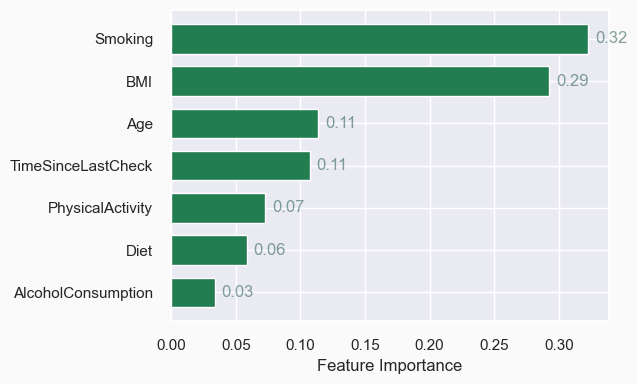

In [85]:
fig, ax = plt.subplots(figsize=(6.5,4), facecolor="#fafafa")
low_lr_ft_plot = ax.barh(np.arange(low_lr_ft_weight.shape[1]), 
               low_lr_ft_weight.iloc[0, :], 
               tick_label=low_lr_ft_weight.columns.values, color="#227D51",
               height=0.7)
ax.invert_yaxis()
ax.set_xlabel("Feature Importance")
ax.bar_label(container = low_lr_ft_plot,
             labels=low_lr_ft_weight.iloc[0,:].round(2),
             padding=5, c="#0F4C3A", alpha=0.5)
plt.tight_layout()
plt.savefig("../figures/low_lr_feature_importance.png", dpi=300, transparent=True)
plt.show()

In [89]:
print(tree_ft_df)
low_tree_ft_weight = copy.deepcopy(tree_ft_df)
low_tree_ft_weight.rename(columns={"Glucose": "Smoking", 
        "DiabetesPedigreeFunction": "TimeSinceLastCheck",
        "BloodPressure": "PhysicalActivity",
        "Insulin": "Diet",
        "SkinThickness": "AlcoholConsumption"
        }, inplace=True)

    Glucose       BMI       Age  BloodPressure  SkinThickness  Insulin   
0  0.626358  0.251138  0.122504            0.0            0.0      0.0  \

   DiabetesPedigreeFunction  
0                       0.0  


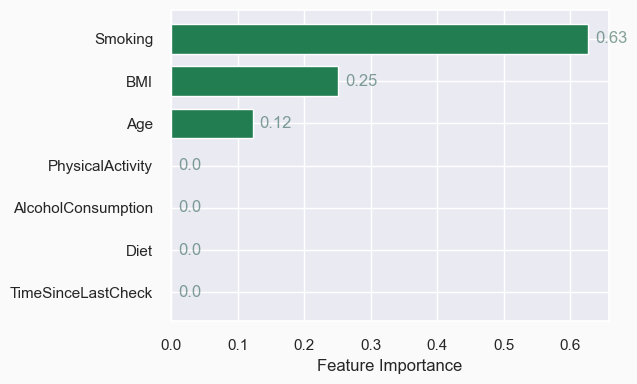

In [90]:
fig, ax = plt.subplots(figsize=(6.5,4), facecolor="#fafafa")
low_tree_ft_plot = ax.barh(np.arange(low_tree_ft_weight.shape[1]), 
               low_tree_ft_weight.iloc[0, :], 
               tick_label=low_tree_ft_weight.columns.values, color="#227D51",
               height=0.7)
ax.invert_yaxis()
ax.set_xlabel("Feature Importance")
ax.bar_label(container = low_tree_ft_plot,
             labels=low_tree_ft_weight.iloc[0,:].round(2),
             padding=5, c="#0F4C3A", alpha=0.5)
plt.tight_layout()
plt.savefig("../figures/low_tree_feature_importance.png", dpi=300, transparent=True)
plt.show()

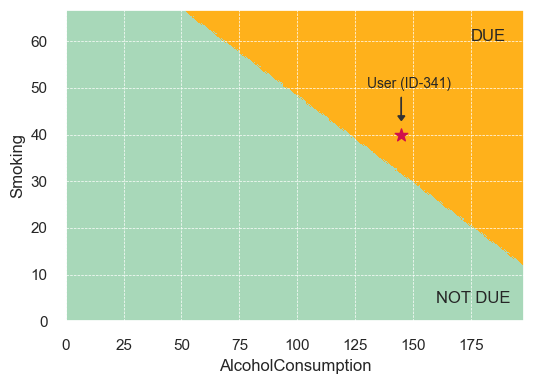

In [67]:
height_values = lr_clf.predict(new_X)
height_values = height_values.reshape(x1_cords.shape)

dots_color_mapping = mpl.colors.ListedColormap(["#7B90D2", "#FAD689"])
fig, ax = plt.subplots(figsize=(5.5, 4))
contour = ax.contourf(
    x1_cords_inver,
    x2_cords_inver,
    height_values,
    levels = 20,
    colors = ["#A8D8B9", "#FFB11B"],
    # cmap = dots_color_mapping,
    zorder = 0,
)

ax.set_xlabel("AlcoholConsumption")
ax.set_ylabel("Smoking")

# set legend
proxy = [plt.Rectangle((0,0),1,1, fc = pc.get_facecolor()[0], edgecolor="white", linewidth=2.0) for pc in [contour.collections[-1], contour.collections[-0]]]
# plt.legend(proxy, ["High Risk", "Low Risk"], loc="lower right", labelcolor = "black" )
plt.text(175, 60, "DUE")
plt.text(160, 4, "NOT DUE")
plt.text(130, 50, "User (ID-341)", fontsize=10)
plt.arrow(145, 48, 0, -5, head_width=3, head_length=1, length_includes_head=True, color="#333333")

ax.scatter(145, 40,
           c="#D0104C",
           edgecolors="#D0104C",
           marker="*",
           s=90)
ax.grid(which='major', color='white', 
        linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("../figures/low_lr_decision_surface.png", dpi=300, transparent=True)
plt.show()

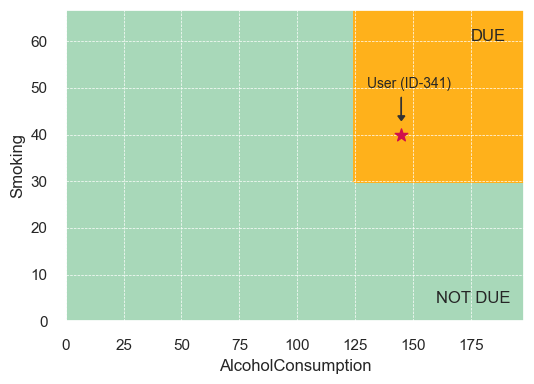

In [68]:
# x1: glucose, x2: BMI
feature1= "Glucose"
feature2= "BMI"
x1_min= np.min(list(X_train[feature1]), axis=0)
x1_max = np.max(list(X_train[feature1]), axis=0)
x2_min = np.min(list(X_train[feature2]), axis=0)
x2_max = np.max(list(X_train[feature2]), axis=0)
h=0.005

x1_cords, x2_cords = np.meshgrid(
    np.arange(x1_min, x1_max, h),
    np.arange(x2_min, x2_max, h)
)

# target point, let's say: 30
target_idx = 157
target_point = X.iloc[target_idx]
# print(target_point)
# print(diabetes_df.iloc[target_idx])
new_combinations = np.c_[x1_cords.ravel(), x2_cords.ravel()]
new_X = pd.DataFrame()
for feature in X_train.columns.values:
    if feature == feature1:
        new_X[feature1] = new_combinations.T[0]
    elif feature == feature2:
        new_X[feature2] = new_combinations.T[1]
    else:
        new_X[feature] = target_point[feature]
height_values = tree_clf.predict(new_X)
height_values = height_values.reshape(x1_cords.shape)

# inverse transform the scale of features
x1_cords_inver, x2_cords_inver = np.meshgrid(
    np.arange(diabetes_df[feature1].min(), round(diabetes_df[feature1].max()), round(diabetes_df[feature1].max())/200),
    np.arange(diabetes_df[feature2].min(), round(diabetes_df[feature2].max()), round(diabetes_df[feature2].max())/200)
)
# inver_target_point = scaler.inverse_transform(X_train)[target_idx]
inver_target_point = scaler.inverse_transform(X)[target_idx]


dots_color_mapping = mpl.colors.ListedColormap(["#E8B647", "#B5CAA0"])
fig, ax = plt.subplots(figsize=(5.5, 4))
contour = ax.contourf(
    x1_cords_inver,     #x1_cords,
    x2_cords_inver,     #x2_cords,
    height_values,
    levels = 20,
    colors = ["#A8D8B9", "#FFB11B"],
    zorder = 0,

)

ax.set_xlabel("AlcoholConsumption")
ax.set_ylabel("Smoking")

# set legend
proxy = [plt.Rectangle((0,0),1,1, fc = pc.get_facecolor()[0], edgecolor="white", linewidth=2.0) for pc in [contour.collections[-1], contour.collections[0]]]
# plt.legend(proxy, ["High Risk", "Low Risk"], loc="lower right", labelcolor = "black")

plt.text(175, 60, "DUE")
plt.text(160, 4, "NOT DUE")
plt.text(130, 50, "User (ID-341)", fontsize=10)
plt.arrow(145, 48, 0, -5, head_width=3, head_length=1, length_includes_head=True, color="#333333")

ax.scatter(145, 40,
           c="#D0104C",
           edgecolors="#D0104C",
           marker="*",
           s=90)
ax.grid(which='major', color='white', 
        linestyle='--', linewidth=0.5)

# plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/low_dt_decision_surface.png", dpi=300, transparent=True)
plt.show()